# **SetUp**

In [ ]:
# Common
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import clear_output as cls

# Data
from glob import glob
from tqdm import tqdm
import tensorflow.data as tfd

# Data Visualization
import matplotlib.pyplot as plt

# Model
from tensorflow import keras
from tensorflow.keras import callbacks
from tensorflow.keras import layers

In [ ]:
# Image Size
IMG_WIDTH = 200
IMG_HEIGHT = 50
IMAGE_SIZE = (IMG_WIDTH, IMG_HEIGHT)

# Batch Size
BATCH_SIZE = 16

# EPOCHS
EPOCHS = 100

# Model Name
MODEL_NAME = 'Handwritten-OCR'

# Callbacks
CALLBACKS = [
    callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    callbacks.ModelCheckpoint(filepath=MODEL_NAME + ".h5", save_best_only=True)
]

# Learning Rate
LEARNING_RATE = 1e-3

# Random Seed
np.random.seed(2569)
tf.random.set_seed(2569)

# File Paths
train_csv_path = '/kaggle/input/handwriting-recognitionocr/CSV/written_name_train.csv'
valid_csv_path = '/kaggle/input/handwriting-recognitionocr/CSV/written_name_validation.csv'
test_csv_path = '/kaggle/input/handwriting-recognitionocr/CSV/written_name_test.csv'

train_image_dir = '/kaggle/input/handwriting-recognitionocr/train_v2/train'
valid_image_dir = '/kaggle/input/handwriting-recognitionocr/validation_v2/validation'
test_image_dir = '/kaggle/input/handwriting-recognitionocr/test_v2/test'

# Data Size
TRAIN_SIZE = BATCH_SIZE * 1000
VALID_SIZE = BATCH_SIZE * 500
TEST_SIZE  = BATCH_SIZE * 100

# AUTOTUNE
AUTOTUNE = tfd.AUTOTUNE

In [ ]:
# Train CSV
train_csv = pd.read_csv(train_csv_path)[:TRAIN_SIZE]

# Validation CSV
valid_csv = pd.read_csv(valid_csv_path)[:VALID_SIZE]

# Test CSV
test_csv = pd.read_csv(test_csv_path)[:TEST_SIZE]

In [ ]:
train_csv.head()

,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE


In [ ]:
# Get all train labels
train_labels = [str(word) for word in train_csv['IDENTITY'].to_numpy()]
train_labels[:10]

['BALTHAZAR',
 'SIMON',
 'BENES',
 'LA LOVE',
 'DAPHNE',
 'LUCIE',
 'NASSIM',
 'ASSRAOUI',
 'LAVIAN',
 'MAEVA']

From these words, we need to extract the **unique characters**.

In [ ]:
# Unique characters
unique_chars = set(char for word in train_labels for char in word)
n_classes = len(unique_chars)

# Show
print(f"Total number of unique characters : {n_classes}")
print(f"Unique Characters : \n{unique_chars}")

Total number of unique characters : 41
Unique Characters : 
{'r', 'T', '-', 'F', 'I', 'e', 'n', 'M', 'Z', 'R', 'y', 'U', 'H', 'W', 'K', 'P', "'", 'l', 'p', 'L', 'A', 'u', 't', 'J', 'o', 's', 'C', 'E', 'S', 'B', 'Y', 'V', 'O', 'D', 'X', 'Q', ' ', 'c', 'N', 'G', 'a'}


In [ ]:
MAX_LABEL_LENGTH = max(map(len, train_labels))
print(f"Maximum length of a label : {MAX_LABEL_LENGTH}")

Maximum length of a label : 24


In [ ]:
train_csv['FILENAME'] = [train_image_dir + f"/{filename}" for filename in train_csv['FILENAME']]
valid_csv['FILENAME'] = [valid_image_dir + f"/{filename}" for filename in valid_csv['FILENAME']]
test_csv['FILENAME']  = [test_image_dir + f"/{filename}" for filename in test_csv['FILENAME']]

In [ ]:
train_csv.head()

,FILENAME,IDENTITY
0,/kaggle/input/handwriting-recognitionocr/train...,BALTHAZAR
1,/kaggle/input/handwriting-recognitionocr/train...,SIMON
2,/kaggle/input/handwriting-recognitionocr/train...,BENES
3,/kaggle/input/handwriting-recognitionocr/train...,LA LOVE
4,/kaggle/input/handwriting-recognitionocr/train...,DAPHNE


# **Label Preprocessing**

In [ ]:
# Character to numeric value dictionary
char_to_num = layers.StringLookup(
    vocabulary = list(unique_chars),
    mask_token = None
)

# Reverse dictionary
num_to_char = layers.StringLookup(
    vocabulary = char_to_num.get_vocabulary(),
    mask_token = None,
    invert = True
)

# **Data Functions**

In [ ]:
def load_image(image_path : str):
    '''
    This function loads and preprocesses images. It first receives the image path, which is used to
    decode the image as a JPEG using TensorFlow. Then, it converts the image to a tensor and applies
    two processing functions: resizing and normalization. The processed image is then returned by
    the function.

    Argument :
        image_path : The path of the image file to be loaded.

    Return:
        image : The loaded image as a tensor.
    '''

    # Read the Image
    image = tf.io.read_file(image_path)

    # Decode the image
    decoded_image = tf.image.decode_jpeg(contents = image, channels = 1)

    # Convert image data type.
    cnvt_image = tf.image.convert_image_dtype(image = decoded_image, dtype = tf.float32)

    # Resize the image
    resized_image = tf.image.resize(images = cnvt_image, size = (IMG_HEIGHT, IMG_WIDTH))

    # Transpose
    image = tf.transpose(resized_image, perm = [1, 0, 2])

    # Convert image to a tensor.
    image = tf.cast(image, dtype = tf.float32)

    # Return loaded image
    return image

In [ ]:
def encode_single_sample(image_path : str, label : str):

    '''
    The function takes an image path and label as input and returns a dictionary containing the processed image tensor and the label tensor.
    First, it loads the image using the load_image function, which decodes and resizes the image to a specific size. Then it converts the given
    label string into a sequence of Unicode characters using the unicode_split function. Next, it uses the char_to_num layer to convert each
    character in the label to a numerical representation. It pads the numerical representation with a special class (n_classes)
    to ensure that all labels have the same length (MAX_LABEL_LENGTH). Finally, it returns a dictionary containing the processed image tensor
    and the label tensor.

    Arguments :
        image_path : The location of the image file.
        label      : The text to present in the image.

    Returns:
        dict : A dictionary containing the processed image and label.
    '''

    # Get the image
    image = load_image(image_path)

    # Convert the label into characters
    chars = tf.strings.unicode_split(label, input_encoding='UTF-8')

    # Convert the characters into vectors
    vecs = char_to_num(chars)

    # Pad label
    pad_size = MAX_LABEL_LENGTH - tf.shape(vecs)[0]
    vecs = tf.pad(vecs, paddings = [[0, pad_size]], constant_values=n_classes+1)

    return {'image':image, 'label':vecs}

Now it's time to apply these functions and get our data.

In [ ]:
# Training Data
train_ds = tf.data.Dataset.from_tensor_slices(
    (np.array(train_csv['FILENAME'].to_list()), np.array(train_csv['IDENTITY'].to_list()))
).shuffle(1000).map(encode_single_sample, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Validation data
valid_ds = tf.data.Dataset.from_tensor_slices(
    (np.array(valid_csv['FILENAME'].to_list()), np.array(valid_csv['IDENTITY'].to_list()))
).map(encode_single_sample, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Testing data.
test_ds = tf.data.Dataset.from_tensor_slices(
    (np.array(test_csv['FILENAME'].to_list()), np.array(test_csv['IDENTITY'].to_list()))
).map(encode_single_sample, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [ ]:
print(f"Training Data Size   : {tf.data.Dataset.cardinality(train_ds).numpy() * BATCH_SIZE}")
print(f"Validation Data Size : {tf.data.Dataset.cardinality(valid_ds).numpy() * BATCH_SIZE}")
print(f"Testing Data Size    : {tf.data.Dataset.cardinality(test_ds).numpy() * BATCH_SIZE}")

Training Data Size   : 16000
Validation Data Size : 8000
Testing Data Size    : 1600


That is exactly what we were looking for.

# **Data Visualization**

In [ ]:
def show_images(data, GRID=[4,4], FIGSIZE=(25, 8), cmap='binary_r', model=None, decode_pred=None):

    # Plotting configurations
    plt.figure(figsize=FIGSIZE)
    n_rows, n_cols = GRID

    # Loading Data
    data = next(iter(data))
    images, labels = data['image'], data['label']

    # Iterate over the data
    for index, (image, label) in enumerate(zip(images, labels)):

        # Label processing
        text_label = num_to_char(label)
        text_label = tf.strings.reduce_join(text_label).numpy().decode('UTF-8')
        text_label = text_label.replace("[UNK]", " ").strip()

        # Create a sub plot
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(tf.transpose(image, perm=[1,0,2]), cmap=cmap)
        plt.axis('off')

        if model is not None and decode_pred is not None:
            # Make prediction
            pred = model.predict(tf.expand_dims(image, axis=0))
            pred = decode_pred(pred)[0]
            title = f"True : {text_label}\nPred : {pred}"
            plt.title(title)
        else:
            # add title
            plt.title(text_label)

    # Show the final plot
    cls()
    plt.show()

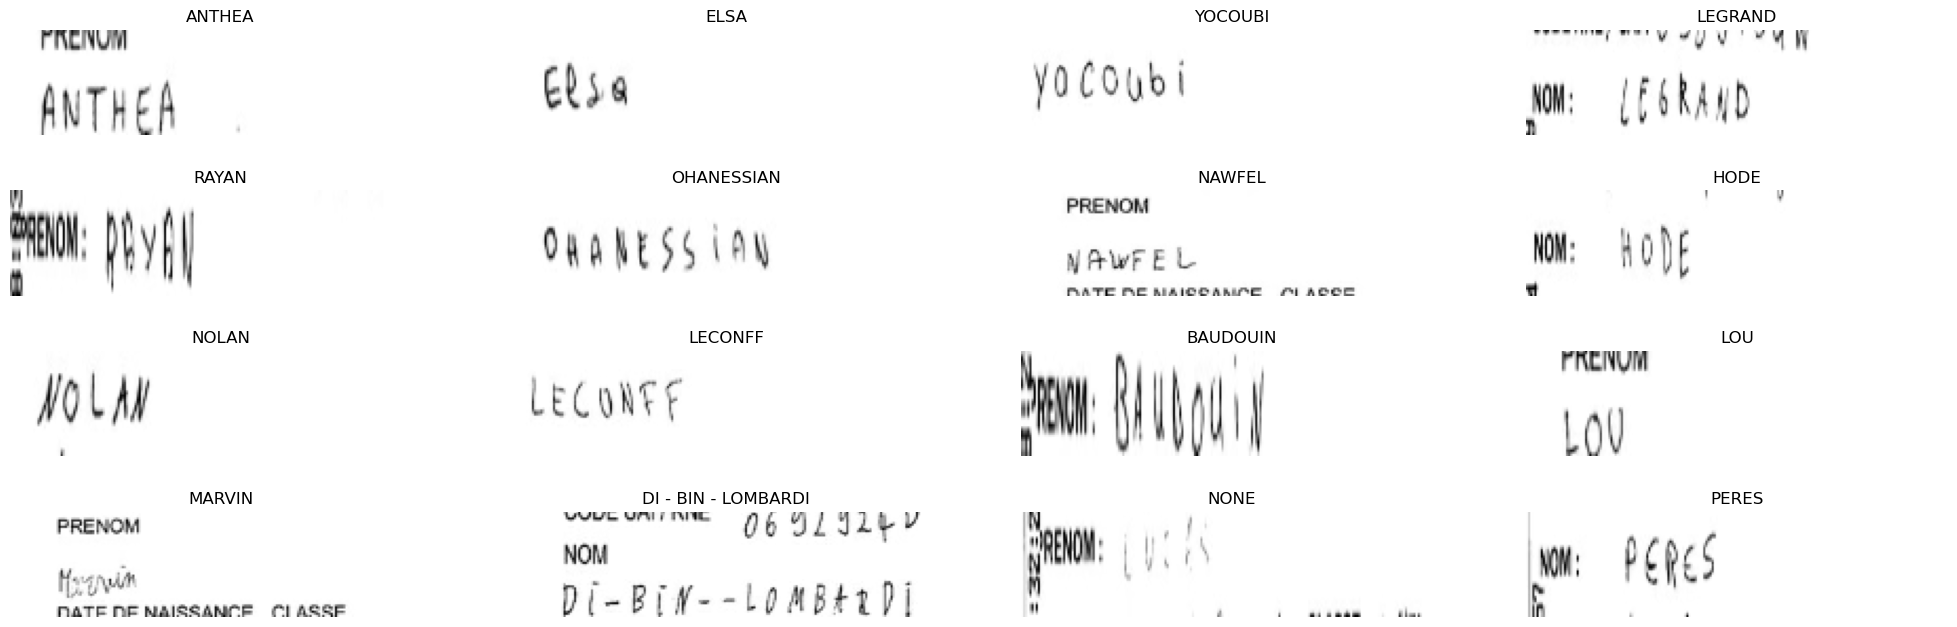

In [ ]:
show_images(data=train_ds, cmap='gray')

In [ ]:
class CTCLayer(layers.Layer):

    def __init__(self, **kwargs) -> None:
        super().__init__(**kwargs)

        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):

        batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')

        input_len = tf.cast(tf.shape(y_pred)[1], dtype='int64') * tf.ones(shape=(batch_len, 1), dtype='int64')
        label_len = tf.cast(tf.shape(y_true)[1], dtype='int64') * tf.ones(shape=(batch_len, 1), dtype='int64')

        loss = self.loss_fn(y_true, y_pred, input_len, label_len)

        self.add_loss(loss)

        return y_pred

OCR MODEL

In [ ]:
# Input Layer
input_images = layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 1), name="image")

# Labels : These are added for the training purpose.
target_labels = layers.Input(shape=(None, ), name="label")

# CNN Network
x = layers.Conv2D(
    filters=32,
    kernel_size=3,
    strides=1,
    padding='same',
    activation='relu',
    kernel_initializer='he_normal'
)(input_images)

x = layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

x = layers.Conv2D(
    filters=64,
    kernel_size=3,
    strides=1,
    padding='same',
    activation='relu',
    kernel_initializer='he_normal'
)(x)

x = layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

# Encoding Space
encoding = layers.Reshape(target_shape=((IMG_WIDTH//4), (IMG_HEIGHT//4)*64))(x)
encoding = layers.Dense(64, activation='relu', kernel_initializer='he_normal')(encoding)
encoding = layers.Dropout(0.2)(encoding)

# RNN Network
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(encoding)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

# Output Layer
output = layers.Dense(len(char_to_num.get_vocabulary())+1, activation='softmax')(x)

# CTC Layer
ctc_layer = CTCLayer()(target_labels, output)

# Model
ocr_model = keras.Model(
    inputs=[input_images, target_labels],
    outputs=[ctc_layer]
)

In [ ]:
# Model Summary
ocr_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 200, 50, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 200, 50, 32)  320         ['image[0][0]']                  
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 100, 25, 32)  0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 100, 25, 64)  18496       ['max_pooling2d[0][0]']      

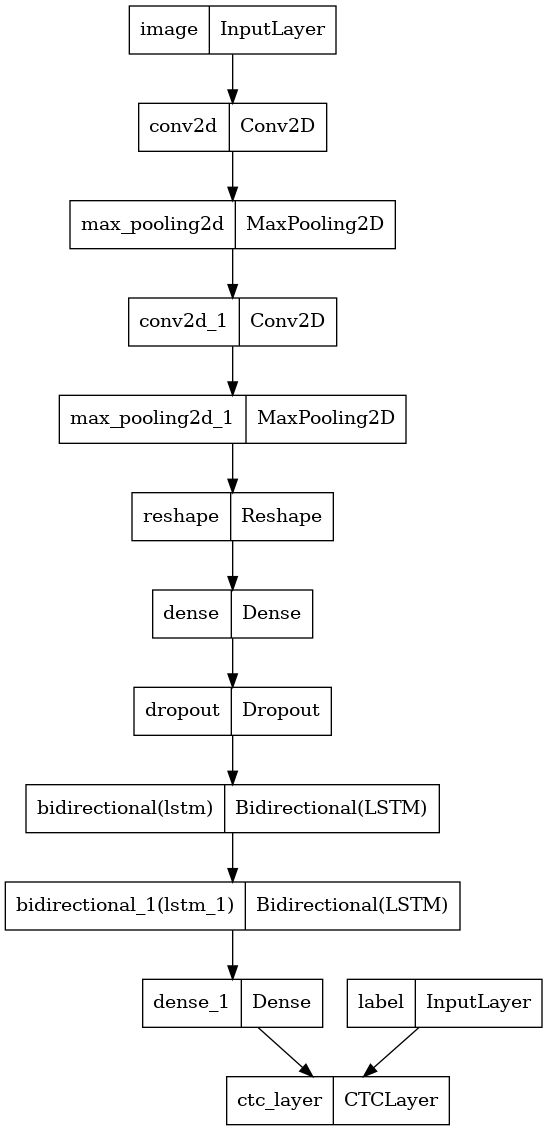

In [ ]:
tf.keras.utils.plot_model(ocr_model)

Our model architecture is ready. It's time to train the model.

In [ ]:
# Compile
ocr_model.compile(optimizer='adam')

# Train
history = ocr_model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=EPOCHS,
    callbacks=CALLBACKS
)

Epoch 1/100
1000/1000 [==============================] - 69s 54ms/step - loss: 20.8548 - val_loss: 19.5602
Epoch 2/100
1000/1000 [==============================] - 29s 29ms/step - loss: 19.0393 - val_loss: 18.7077
Epoch 3/100
1000/1000 [==============================] - 29s 29ms/step - loss: 18.5305 - val_loss: 18.2978
Epoch 4/100
1000/1000 [==============================] - 29s 29ms/step - loss: 17.5980 - val_loss: 16.3718
Epoch 5/100
1000/1000 [==============================] - 29s 29ms/step - loss: 15.1537 - val_loss: 12.9506
Epoch 6/100
1000/1000 [==============================] - 29s 29ms/step - loss: 11.7628 - val_loss: 9.2771
Epoch 7/100
1000/1000 [==============================] - 29s 29ms/step - loss: 9.2394 - val_loss: 7.3389
Epoch 8/100
1000/1000 [==============================] - 29s 29ms/step - loss: 7.6353 - val_loss: 6.1559
Epoch 9/100
1000/1000 [==============================] - 30s 30ms/step - loss: 6.5728 - val_loss: 5.4390
Epoch 10/100
1000/1000 [====================

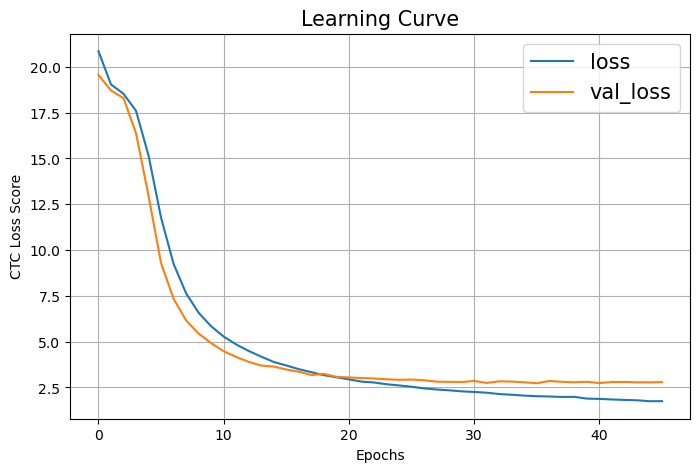

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.legend(fontsize=15)
plt.xlabel("Epochs")
plt.ylabel("CTC Loss Score")
plt.title("Learning Curve", fontsize=15)
plt.grid()
plt.savefig("OCRModel-LearningCurve.png")
plt.show()

In [ ]:
# Model required for inference
inference_model = keras.Model(
    inputs=ocr_model.get_layer(name="image").input,
    outputs=ocr_model.get_layer(name='dense_1').output
)

# Model summary
inference_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 200, 50, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 25, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 25, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 12, 64)       0         
 2D)                                                             
                                                                 
 reshape (Reshape)           (None, 50, 768)           0   

In [ ]:
def decode_pred(pred_label):

    '''
    The decode_pred function is used to decode the predicted labels generated by the OCR model.
    It takes a matrix of predicted labels as input, where each time step represents the probability
    for each character. The function uses CTC decoding to decode the numeric labels back into their
    character values. The function also removes any unknown tokens and returns the decoded texts as a
    list of strings. The function utilizes the num_to_char function to map numeric values back to their
    corresponding characters. Overall, the function is an essential step in the OCR process, as it allows
    us to obtain the final text output from the model's predictions.

    Argument :
        pred_label : These are the model predictions which are needed to be decoded.

    Return:
        filtered_text : This is the list of all the decoded and processed predictions.

    '''

    # Input length
    input_len = np.ones(shape=pred_label.shape[0]) * pred_label.shape[1]

    # CTC decode
    decode = keras.backend.ctc_decode(pred_label, input_length=input_len, greedy=True)[0][0][:,:MAX_LABEL_LENGTH]

    # Converting numerics back to their character values
    chars = num_to_char(decode)

    # Join all the characters
    texts = [tf.strings.reduce_join(inputs=char).numpy().decode('UTF-8') for char in chars]

    # Remove the unknown token
    filtered_texts = [text.replace('[UNK]', " ").strip() for text in texts]

    return filtered_texts

Let's see this function working.

In [ ]:
print(decode_pred(inference_model.predict(test_ds)))

/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:638: UserWarning: Input dict contained keys ['label'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


100/100 [==============================] - 5s 33ms/step
['KEVIN', 'LMn', 'LENA', 'JULES', 'CHERPIN', 'MARTIN', 'VALENTINE', 'LORAS', 'THIBAULT', 'AGABI', 'GORICHAROFF', 'MAHENTHIRAN', 'FRANEISSPIEA', 'JEANNE', 'DEBORAH', 'DROUES', 'JOAC', 'CORWIL FRERROT', 'CLEMENT', 'RELIS', 'NAHIZATA FATIN', 'FOURNEL', 'DICINTIOILLESCA', 'BARDOT', 'DUVAL', 'ANTONY', 'LISA', 'CELHA', 'GRODZKI', 'HUGO', 'HUGO', 'ELOUEN', 'SCNOCMAECKER', 'HOARAU', 'STEENKERSTE', 'DIFFONE', 'BUIBEY', 'RONAN', 'MILLE', 'CAROLINE', 'PAUL', 'BECHARA', 'DIBOS', 'JENNCONE', 'DREMIY', 'CLOUIS', 'JORIS', 'MARUINI', 'CLAIRE', 'RAFFORT', 'ICHOROTS', 'DEBUYSSCHER', 'ALEXANORE', 'RAPHAEL', 'KHIRERDINE', 'UART', 'GOURAUD', 'ROMAN', 'LEBERNAN', 'POBIER', 'HARDY', 'ALEXANDRE', 'BOULANGER', 'MARWANE', 'PARIS', 'MELANIE', 'NOUAZE', 'LEVRIT', 'PARENT', 'DECCMENES', 'HAHAULT', 'DAGOAG', 'DUCHAINE', 'AYOUL', 'KARIN', 'ALGRIA', 'EZSAR', 'BERAUCHET', 'KEVIN', 'ZAMBRIFI', 'ALESSI', 'CHARLES', 'ELIA', 'ALEXANDRE', 'ROY-COUTELLIER', 'LEILI', 'M

This function seems to **work perfectly fine** for **decoding the predicted labels**, but to gain better **insight and understanding**, it would be beneficial to have a **visual representation** of the **model's predictions**.

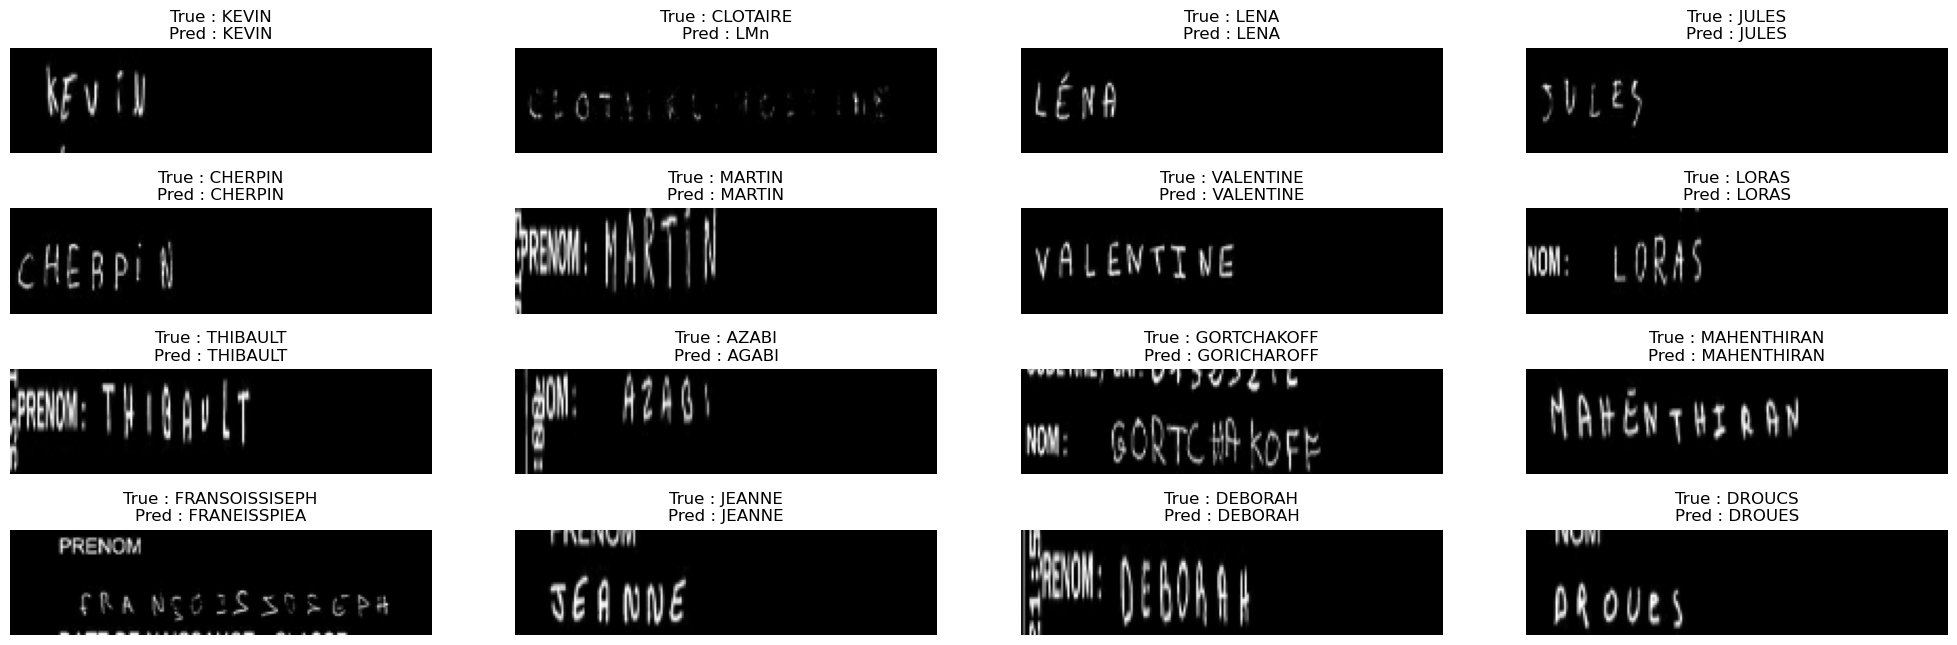

In [ ]:
show_images(data=test_ds, model=inference_model, decode_pred=decode_pred, cmap='binary')

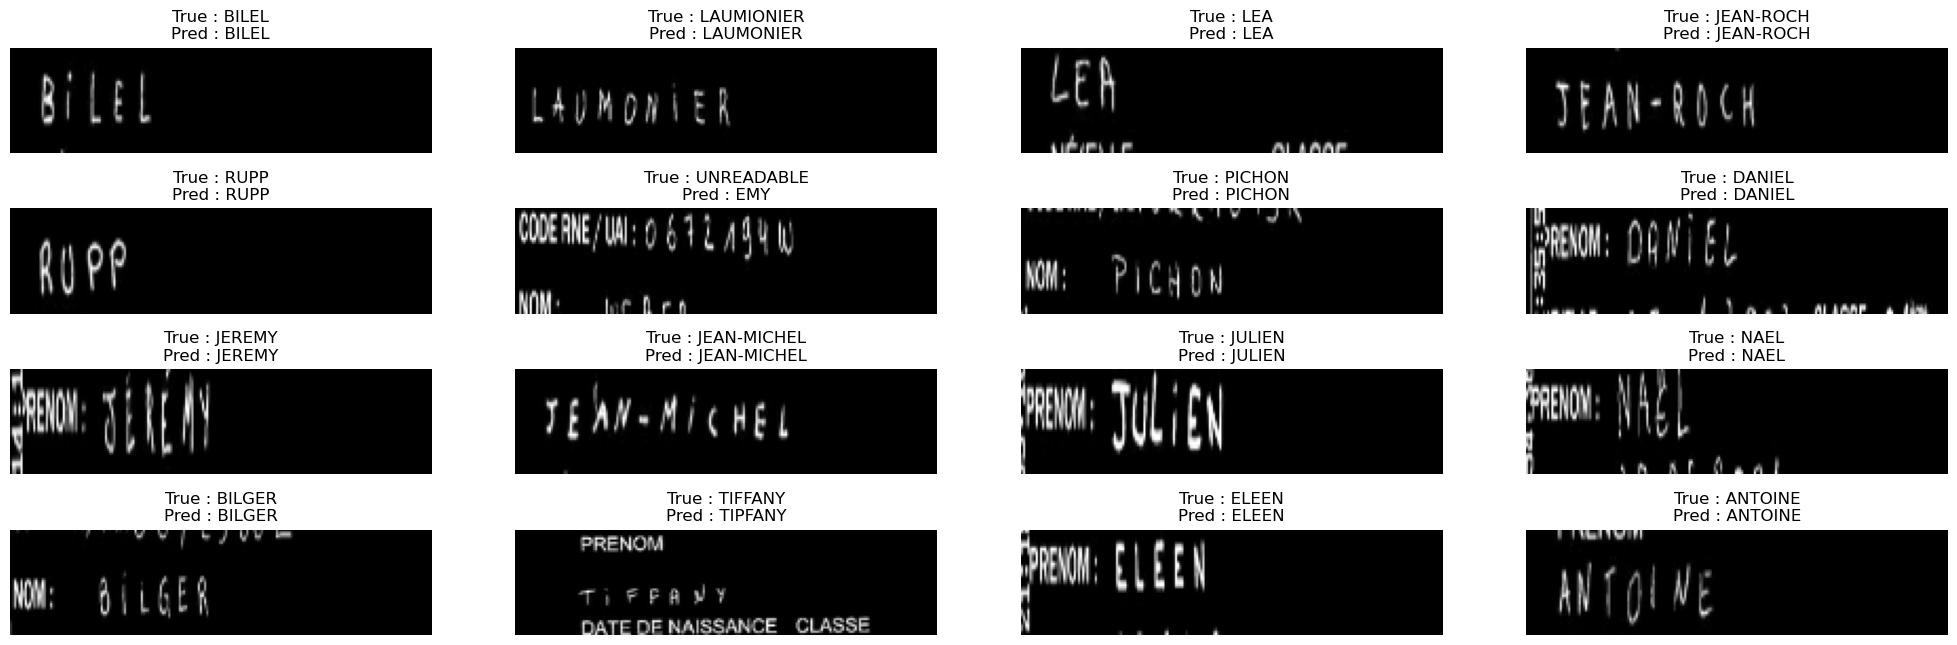

In [ ]:
show_images(data=valid_ds, model=inference_model, decode_pred=decode_pred, cmap='binary')

# **OCR Model - Improved**

Let's try to change the model architecture,

Epoch 1/100
1000/1000 [==============================] - 46s 36ms/step - loss: 20.1161 - val_loss: 18.7730
Epoch 2/100
1000/1000 [==============================] - 35s 35ms/step - loss: 18.5969 - val_loss: 18.4844
Epoch 3/100
1000/1000 [==============================] - 35s 35ms/step - loss: 18.2918 - val_loss: 18.0748
Epoch 4/100
1000/1000 [==============================] - 35s 35ms/step - loss: 17.2236 - val_loss: 15.7969
Epoch 5/100
1000/1000 [==============================] - 34s 34ms/step - loss: 12.9790 - val_loss: 8.5992
Epoch 6/100
1000/1000 [==============================] - 34s 34ms/step - loss: 6.7508 - val_loss: 4.7356
Epoch 7/100
1000/1000 [==============================] - 34s 34ms/step - loss: 4.3890 - val_loss: 3.6011
Epoch 8/100
1000/1000 [==============================] - 34s 34ms/step - loss: 3.3826 - val_loss: 3.0478
Epoch 9/100
1000/1000 [==============================] - 34s 34ms/step - loss: 2.8379 - val_loss: 2.8987
Epoch 10/100
1000/1000 [======================

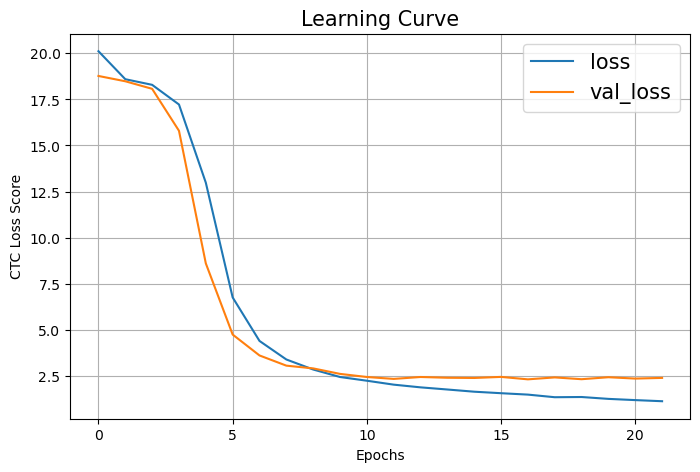

In [ ]:
# Input Layer
input_images = layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 1), name="image")

# Labels : These are added for the training purpose.
target_labels = layers.Input(shape=(None, ), name="label")

# CNN Network
x = layers.Conv2D(
    filters=32,
    kernel_size=3,
    strides=1,
    padding='same',
    activation='relu',
    kernel_initializer='he_normal'
)(input_images)

x = layers.Conv2D(
    filters=32,
    kernel_size=3,
    strides=1,
    padding='same',
    activation='relu',
    kernel_initializer='he_normal'
)(x)

x = layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

x = layers.Conv2D(
    filters=64,
    kernel_size=3,
    strides=1,
    padding='same',
    activation='relu',
    kernel_initializer='he_normal'
)(x)

x = layers.Conv2D(
    filters=128,
    kernel_size=3,
    strides=1,
    padding='same',
    activation='relu',
    kernel_initializer='he_normal'
)(x)

x = layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

# Encoding Space
encoding = layers.Reshape(target_shape=((IMG_WIDTH//4), (IMG_HEIGHT//4)*128))(x)
encoding = layers.Dense(64, activation='relu', kernel_initializer='he_normal')(encoding)
encoding = layers.Dense(128, activation='relu', kernel_initializer='he_normal')(encoding)
encoding = layers.Dropout(0.4)(encoding)

# RNN Network
x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.25))(encoding)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)

# Output Layer
output = layers.Dense(len(char_to_num.get_vocabulary())+1, activation='softmax')(x)

# CTC Layer
ctc_layer = CTCLayer()(target_labels, output)

# Model
ocr_model_2 = keras.Model(
    inputs=[input_images, target_labels],
    outputs=[ctc_layer]
)

# Compile
ocr_model_2.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3))

# Train
history_2 = ocr_model_2.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=EPOCHS,
    callbacks=[
        callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)

# Learning Curve
pd.DataFrame(history_2.history).plot(figsize=(8,5))
plt.legend(fontsize=15)
plt.xlabel("Epochs")
plt.ylabel("CTC Loss Score")
plt.title("Learning Curve", fontsize=15)
plt.grid()
# plt.savefig("OCRModel-LearningCurve.png")
plt.show()

In [ ]:
# Model required for inference
inference_model_2 = keras.Model(
    inputs=ocr_model_2.get_layer(name="image").input,
    outputs=ocr_model_2.get_layer(name='dense_4').output
)

# Model summary
inference_model_2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 200, 50, 32)       320       
                                                                 
 conv2d_3 (Conv2D)           (None, 200, 50, 32)       9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 100, 25, 32)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 100, 25, 64)       18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 100, 25, 128)      73856     
                                                           

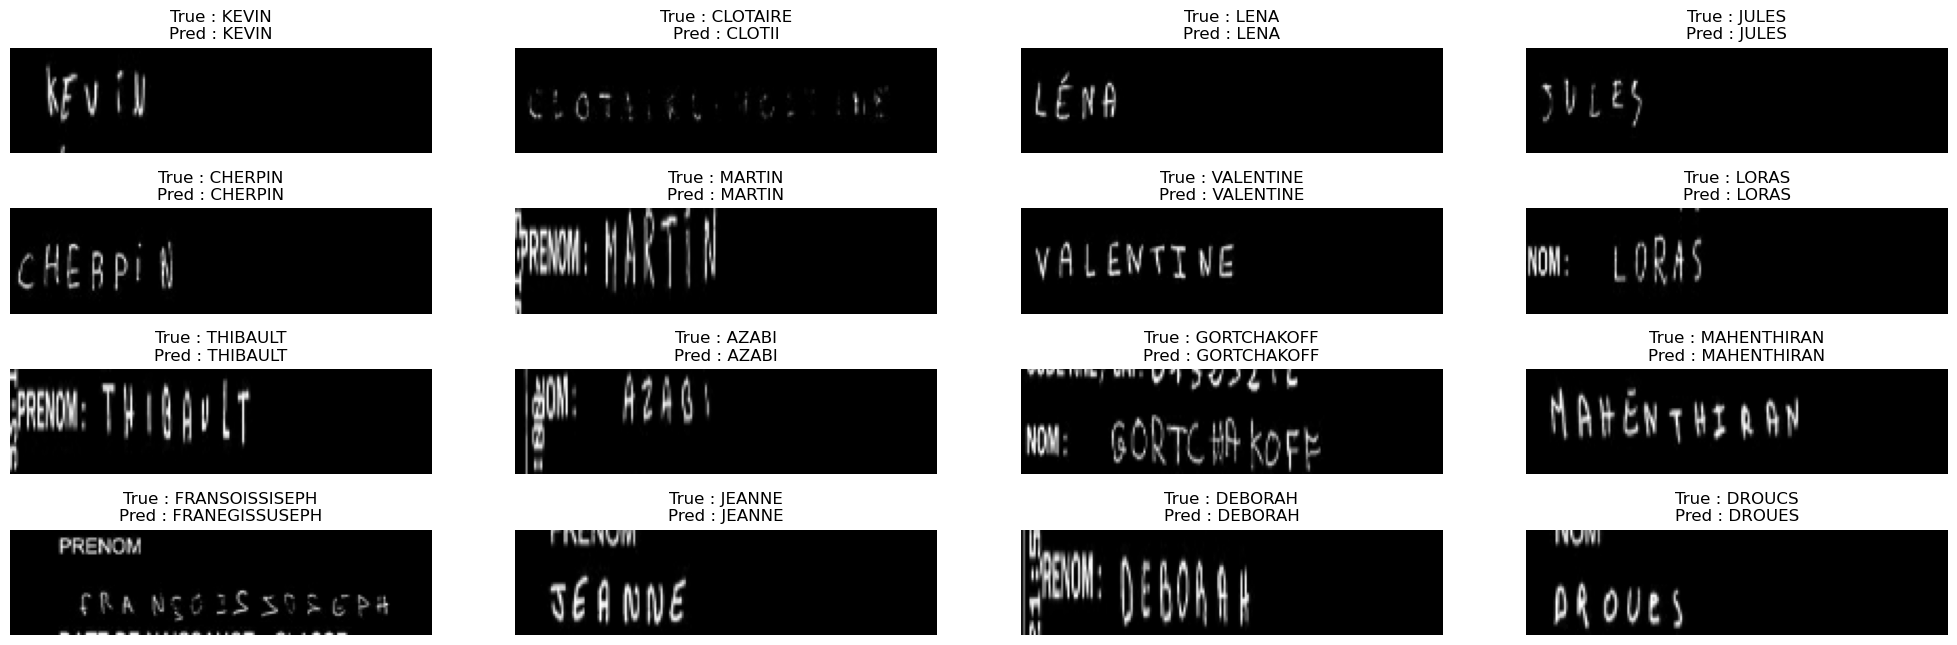

In [ ]:
show_images(data=test_ds, model=inference_model_2, decode_pred=decode_pred, cmap='binary')

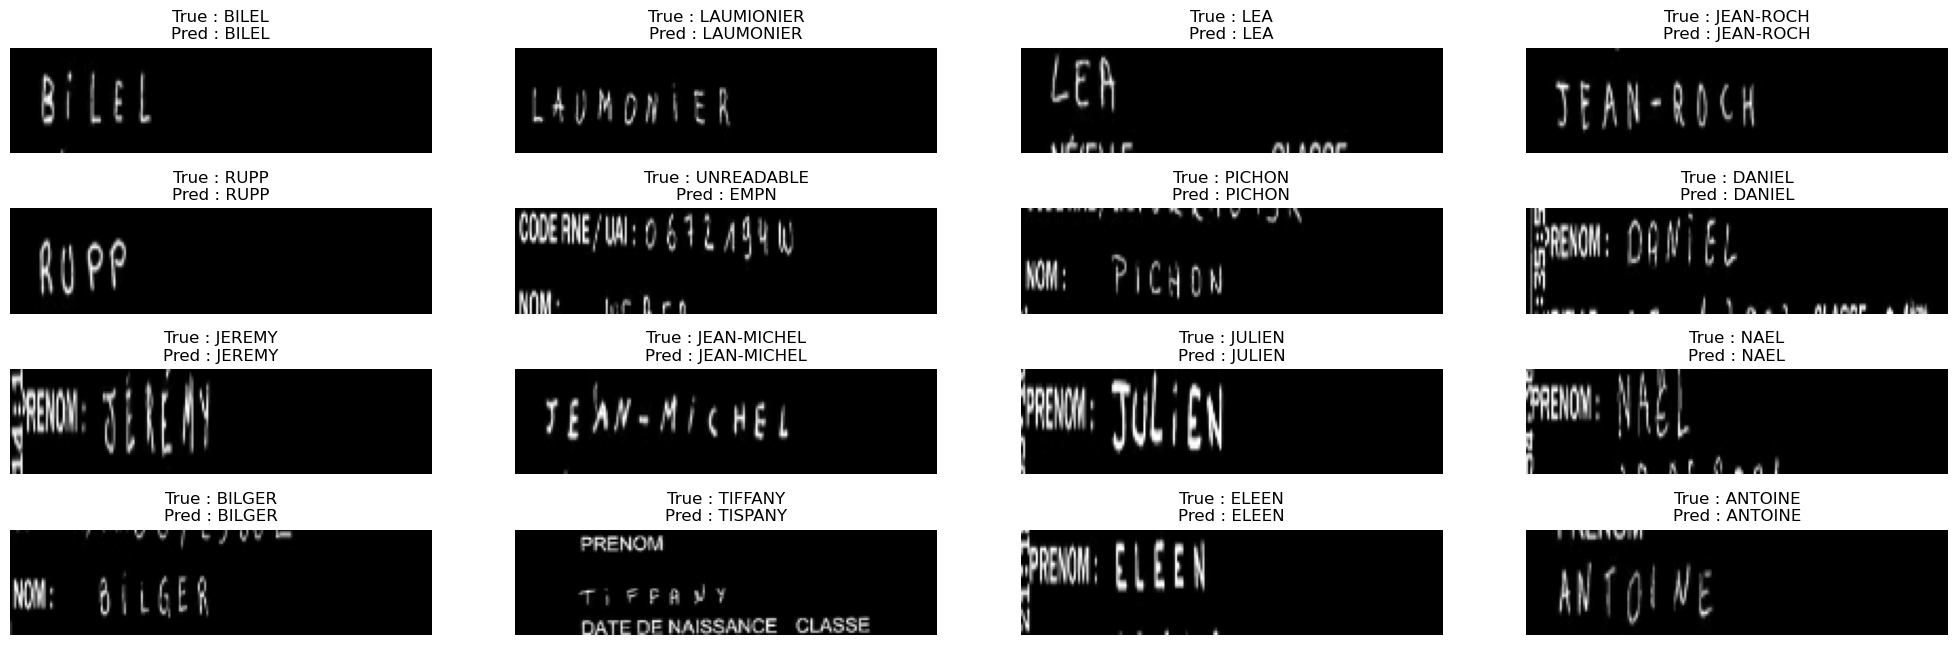

In [ ]:
show_images(data=valid_ds, model=inference_model_2, decode_pred=decode_pred, cmap='binary')